## Notebook for calculating Pearson correlations between variables, as well as Information Gain

In [26]:
import sys
sys.path.append('../')
from data_loader import DataLoader
import random
from feature_selector import BaselineSelector, AnalysisSelector
from feature_selector import FeatureExtractor
import numpy as np

In [27]:
loader = DataLoader('../data/dataset', participants_ids=list(range(88)))
selectors = [None] * 19
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [28]:

mean_cum_sum = np.zeros((19, ))
mean_pca_var = np.zeros((19, ))

for i in range(len(loader)):
    data = loader[i]['data']
    pca = PCA()
    pca.fit(data)
    exp_var_pca = pca.explained_variance_ratio_
    mean_pca_var += exp_var_pca

    cum_sum_eigenvalues = np.cumsum(exp_var_pca)
    mean_cum_sum += cum_sum_eigenvalues

mean_cum_sum /= len(loader)
mean_pca_var /= len(loader)


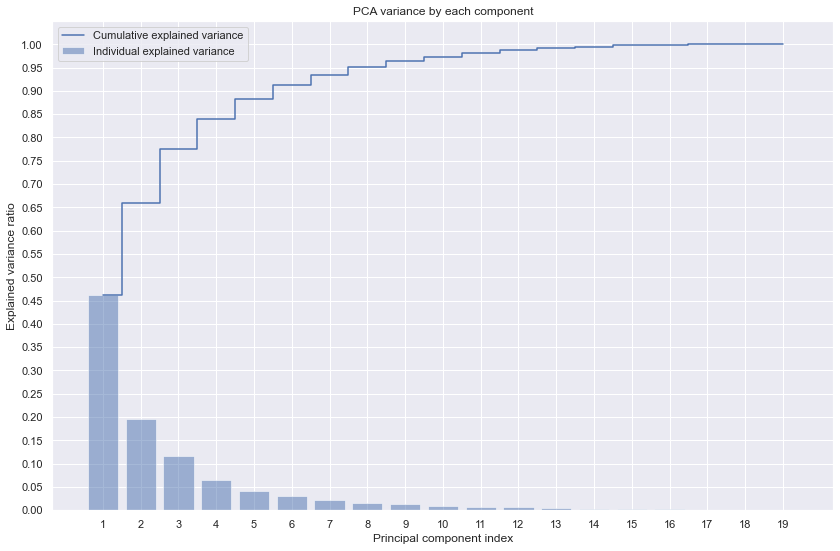

In [30]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(14, 9))
plt.grid()
sns.set(style='darkgrid')
plt.grid()
plt.bar(range(1,len(mean_pca_var)+1), mean_pca_var, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(1,len(mean_cum_sum)+1), mean_cum_sum, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.xticks(list(range(1, 20)))
plt.yticks(np.arange(0, 1.05, 0.05))

plt.title('PCA variance by each component')
plt.savefig('../data/plots/pca/pca.png', dpi = 300)
plt.show()

### Sa ovog grafika mozemo videti da ako uzmemo 8 komponenti, hvatamo preko 95% varijance u podacima. Tako da cemo koristiti 8 komponenti PCA za dalju analizu.

In [35]:
selector = AnalysisSelector()
selector.selectFeatures(['mean', 'std', 'kurtosis', 'band_power', 'hjorth_params'], pca_components=8, bands = ['alpha', 'beta', 'gamma', 'theta'], params = ['activity', 'mobility', 'complexity'])

In [36]:
tmp = selector.transform(loader[0]['data'])
cols = list(tmp.keys())

In [37]:
features = None
targets = []
for i, sample in enumerate(loader):
    data = sample['data']
    f = selector.transform(data)
    targets.append(sample['group'])
    if features is None:
        features = np.expand_dims(f, axis=0)
    else:
        features = np.concatenate((features, np.expand_dims(f, axis=0)), axis=0)
        if i % 1000 == 0:
            print(f'{i} samples processed')
            
        

1000 samples processed
2000 samples processed
3000 samples processed
4000 samples processed
5000 samples processed
6000 samples processed
7000 samples processed
8000 samples processed
9000 samples processed
10000 samples processed
11000 samples processed
12000 samples processed
13000 samples processed


### Pearson correlation

In [40]:
# plot pearson correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# for each channel, compute the correlation matrix
corr_matrices = []
df = [None] * 8
for k in range(8):
    df[k] = pd.DataFrame([[features[i][col][k] for col in cols] for i in range(features.shape[0])], columns=cols)
    


<ipython-input-42-d0697f49bcf7>:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.ones_like(corr, dtype=np.bool)


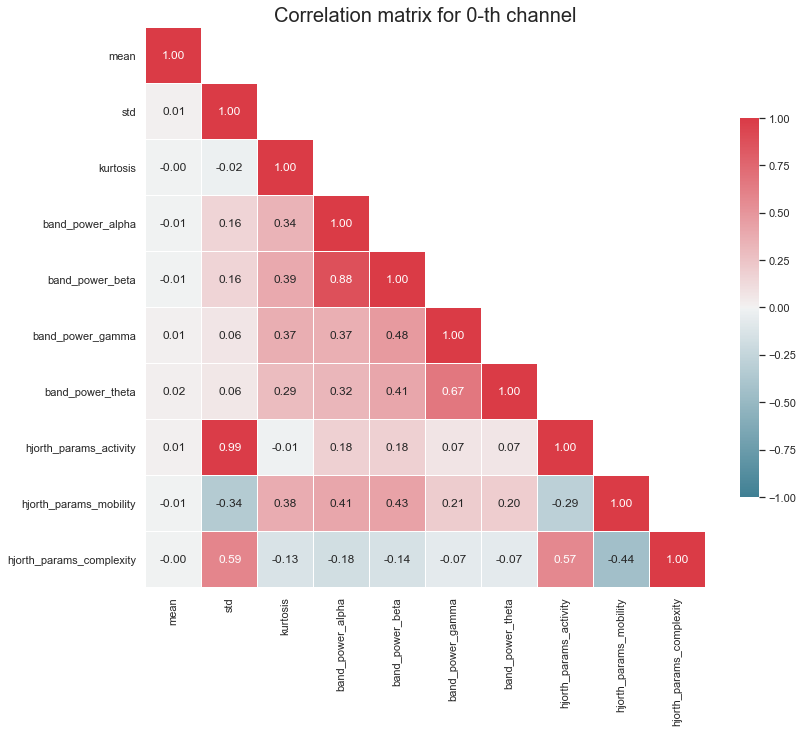

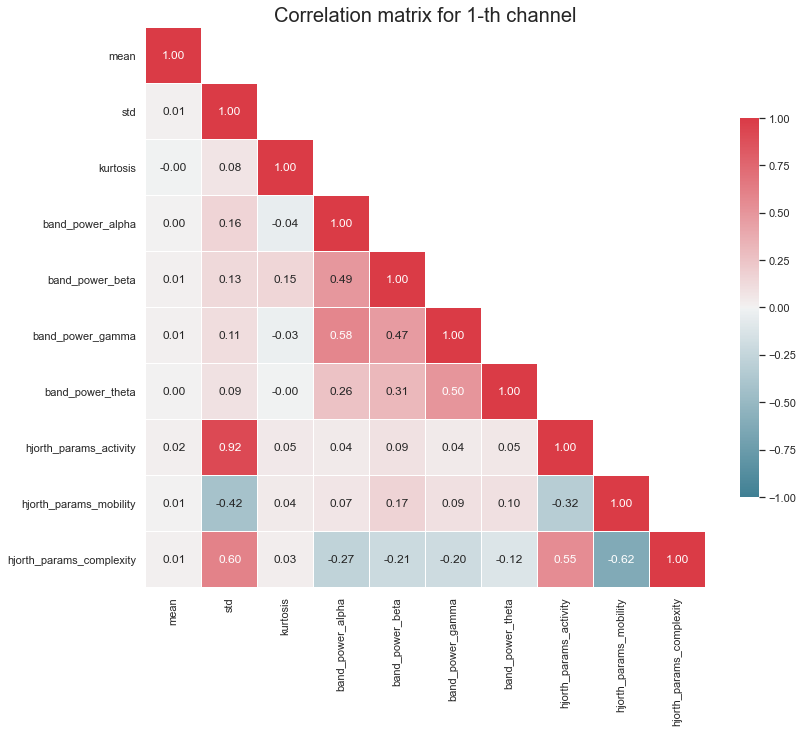

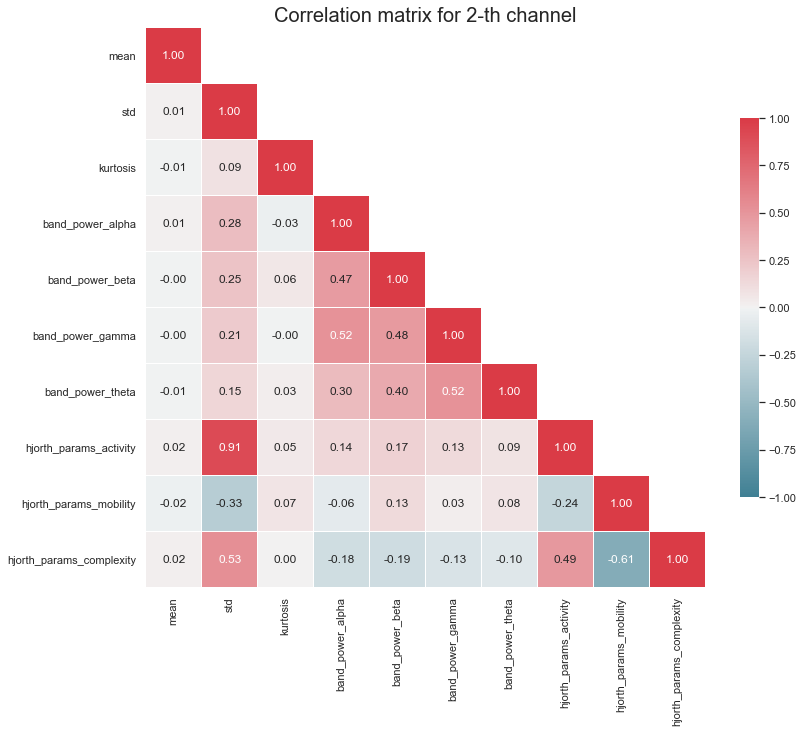

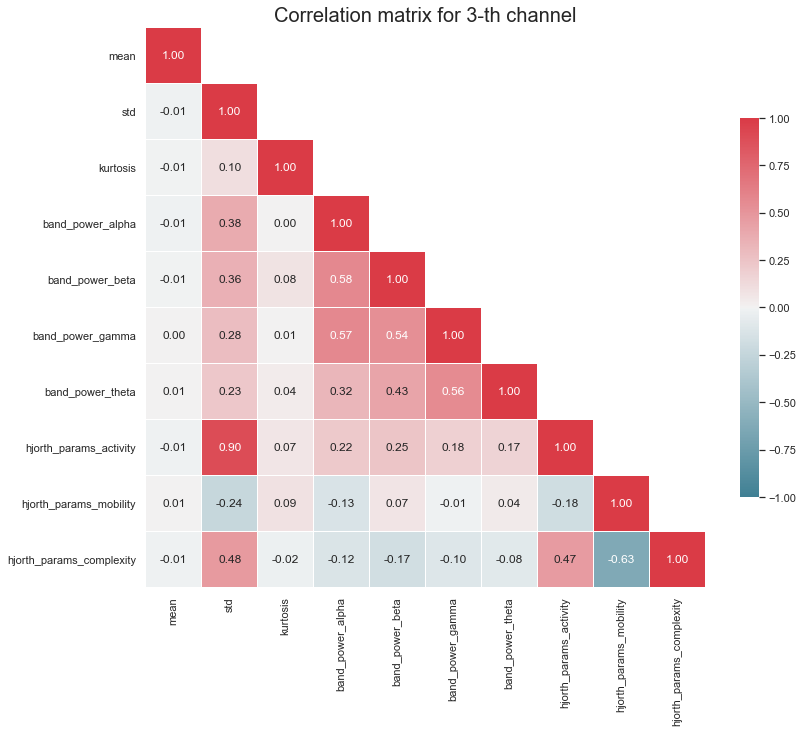

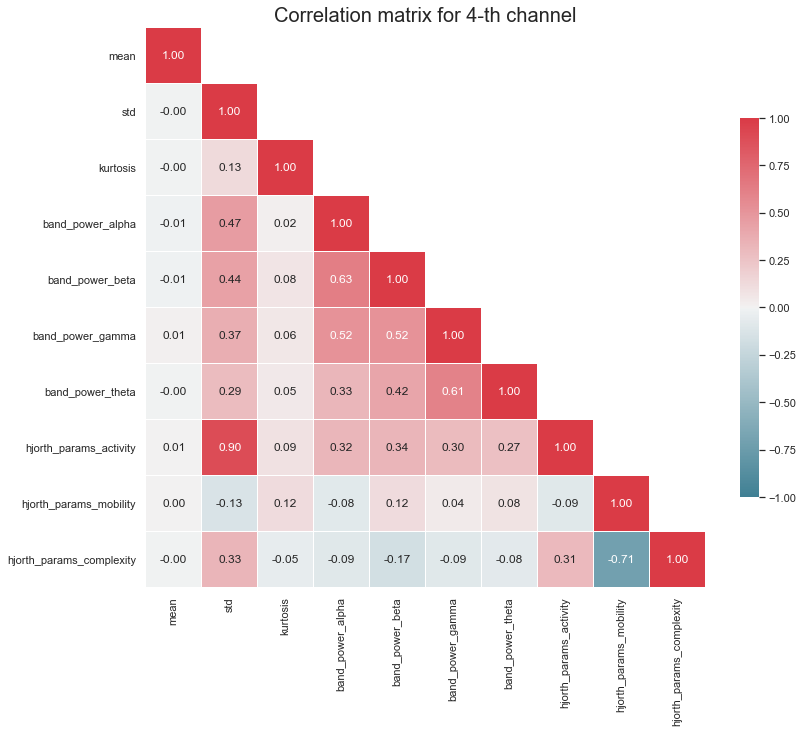

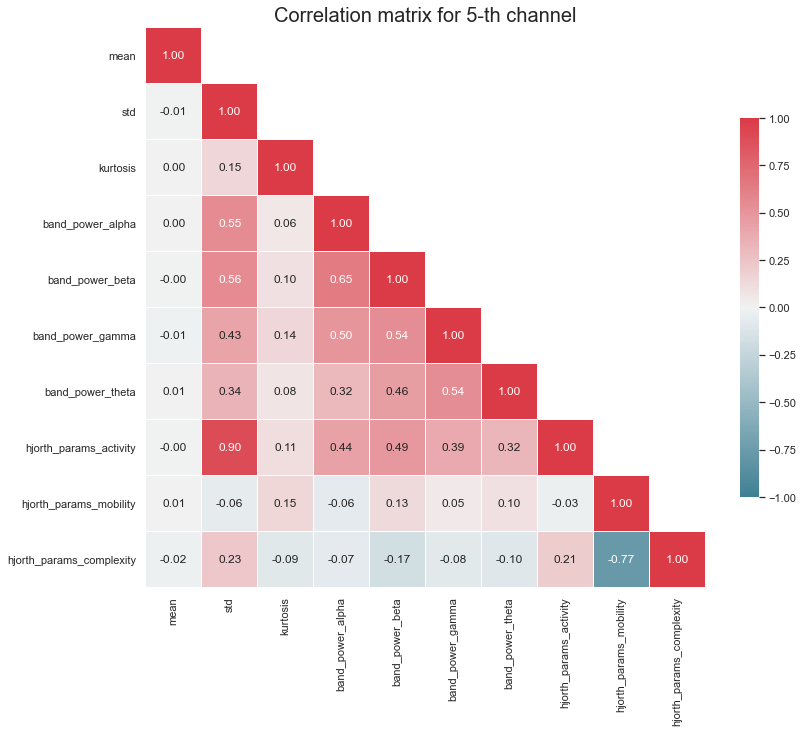

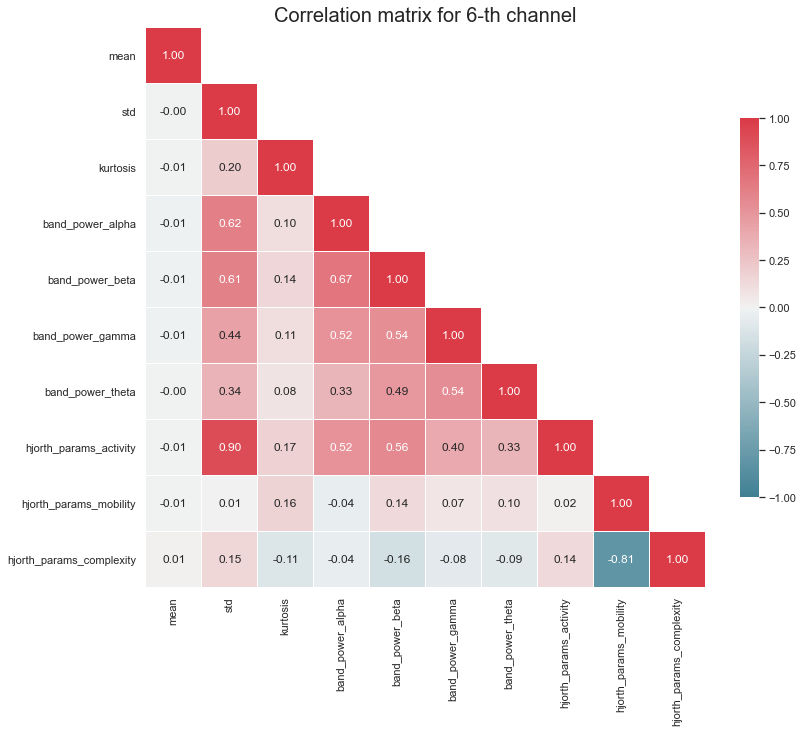

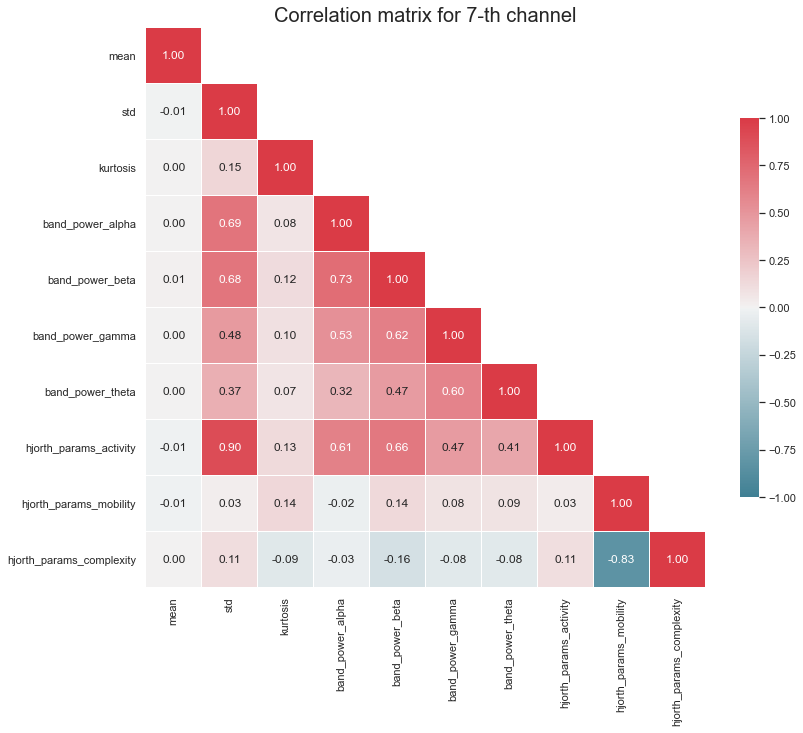

In [42]:
for k in range(8):
    corr = df[k].corr()

    sns.set(style="white")
    mask = np.ones_like(corr, dtype=np.bool)
    mask[np.tril_indices_from(mask)] = False
    
    fig, ax = plt.subplots(figsize=(12, 12))
    
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt='.2f')
    
    # add margin to the figure


    plt.tight_layout()

    plt.title(f'Correlation matrix for {k}-th channel', fontdict = {'fontsize' : 20})
    plt.savefig(f'../data/plots/correlation/corr_matrix_{k}.png', dpi = 300)


### Information Gain

In [43]:
from sklearn.feature_selection import mutual_info_classif


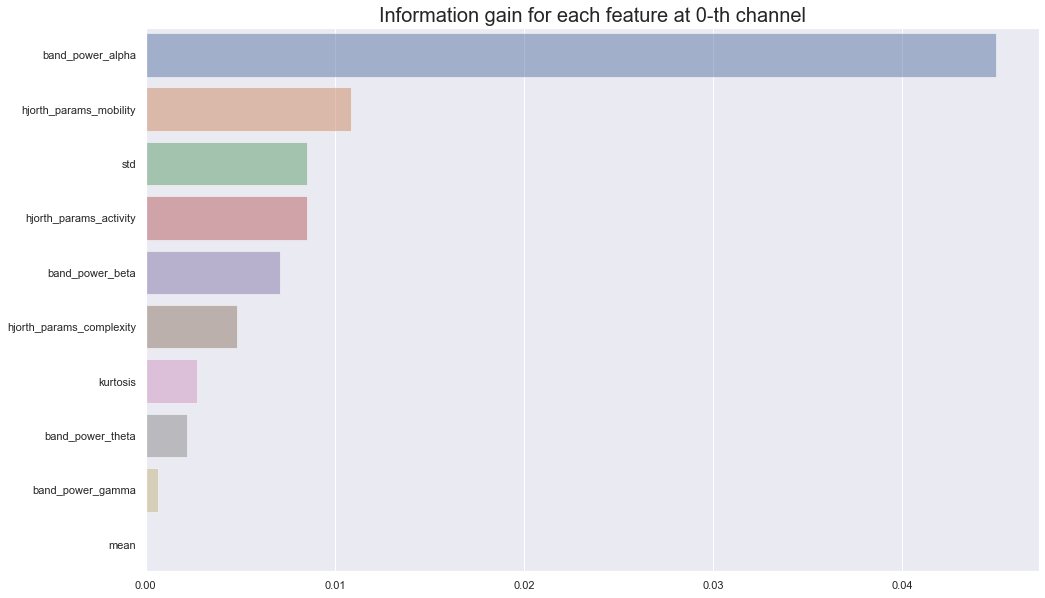

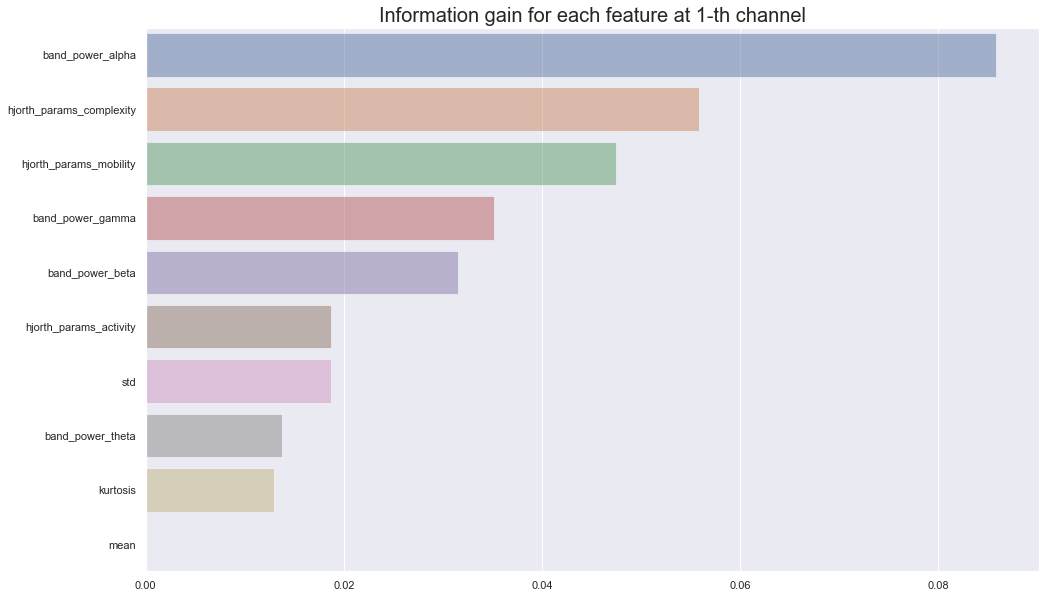

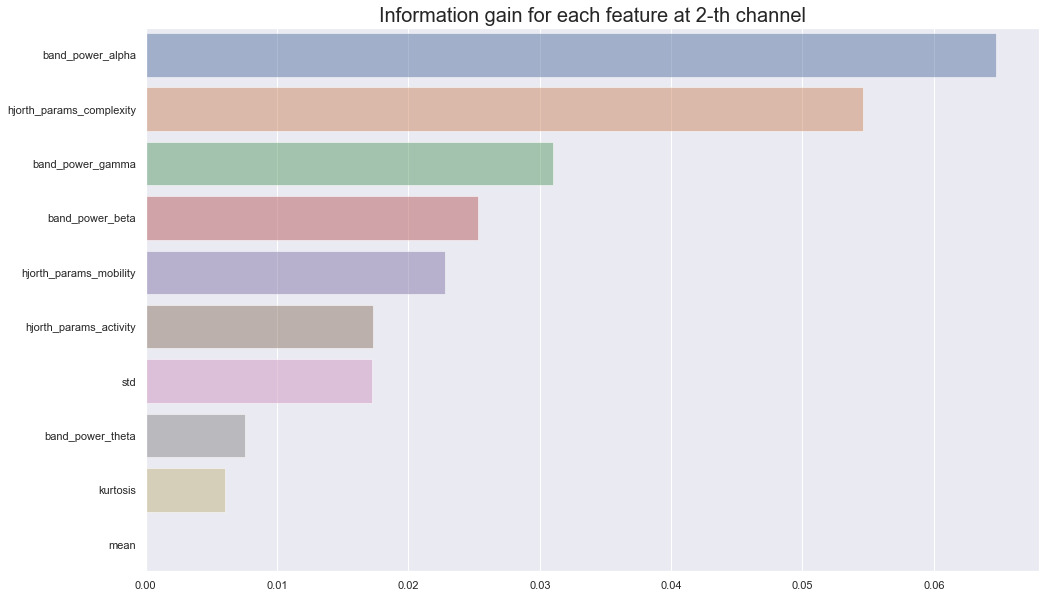

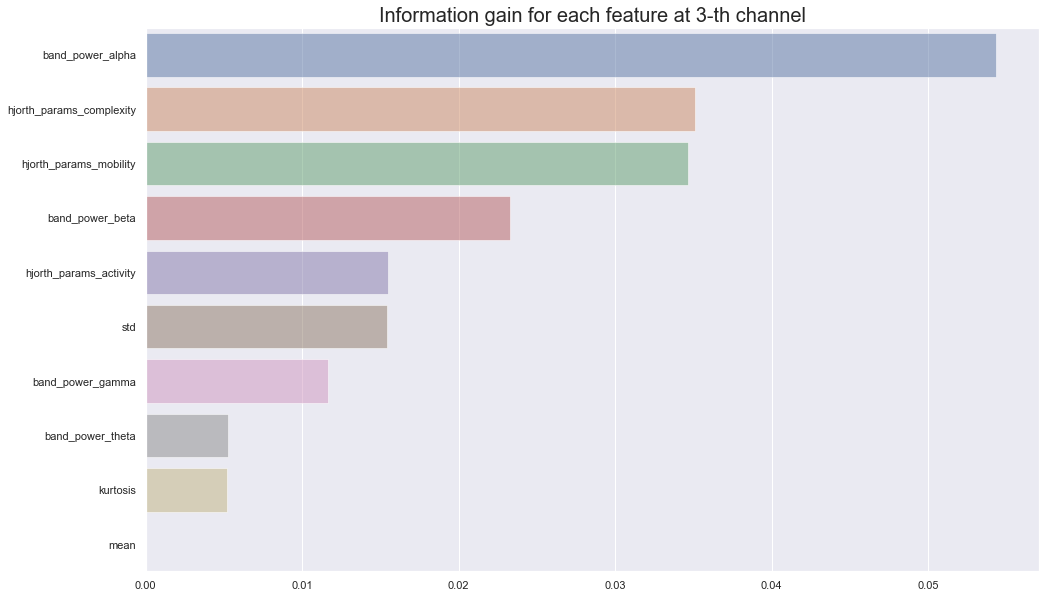

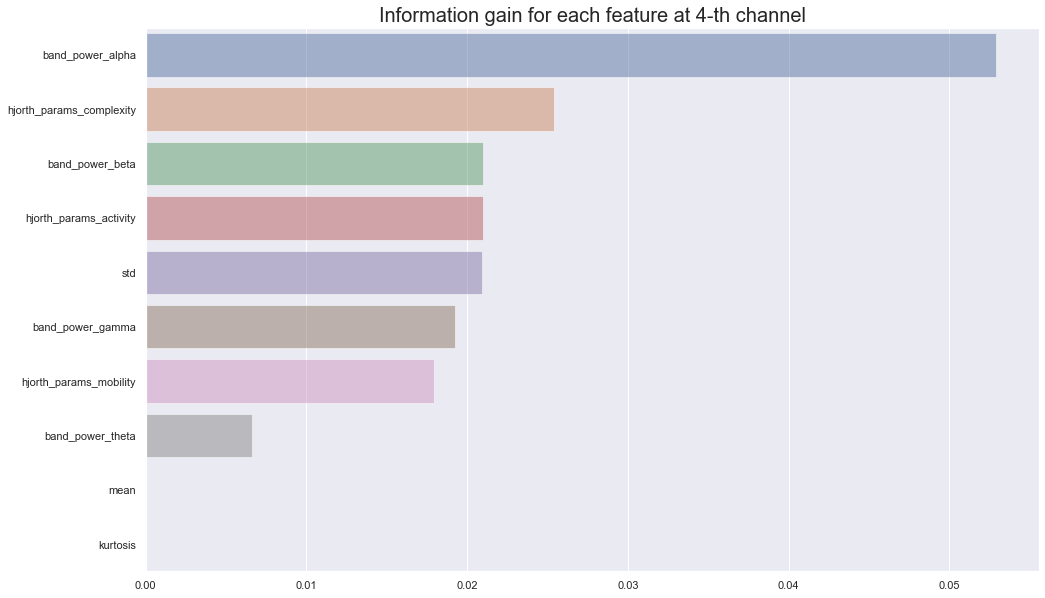

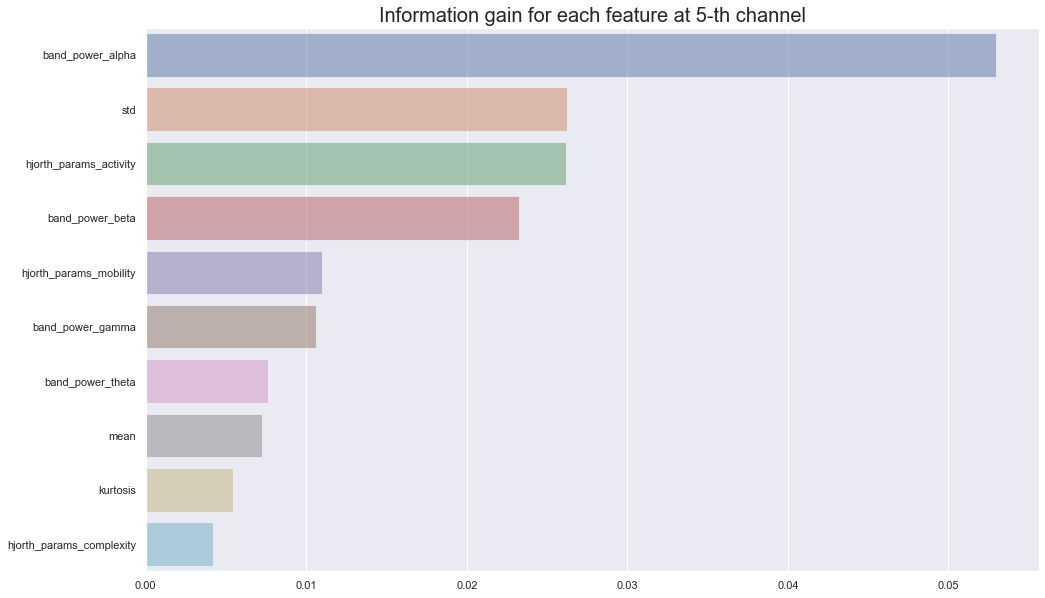

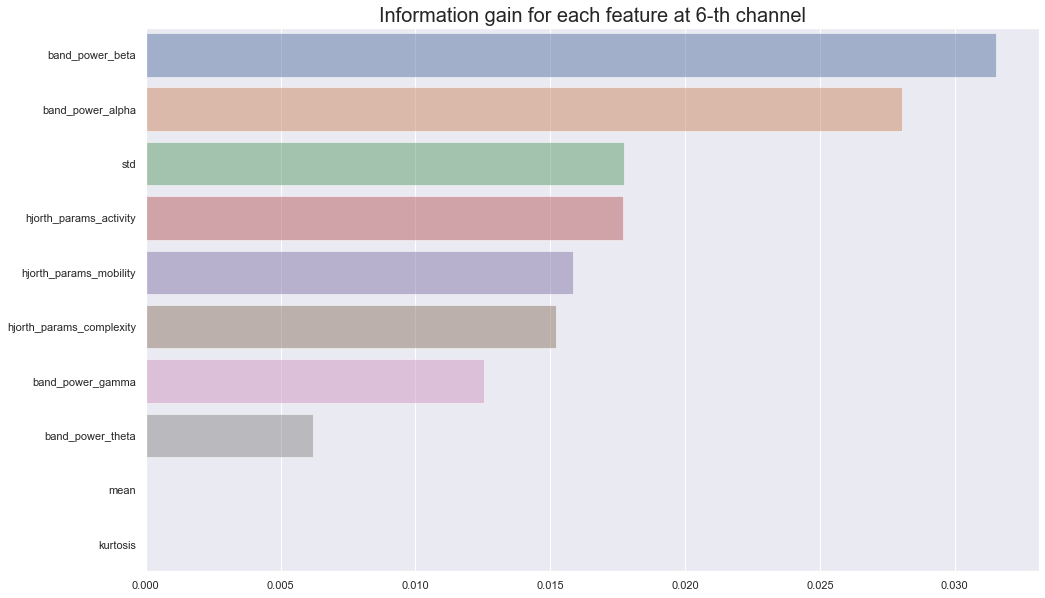

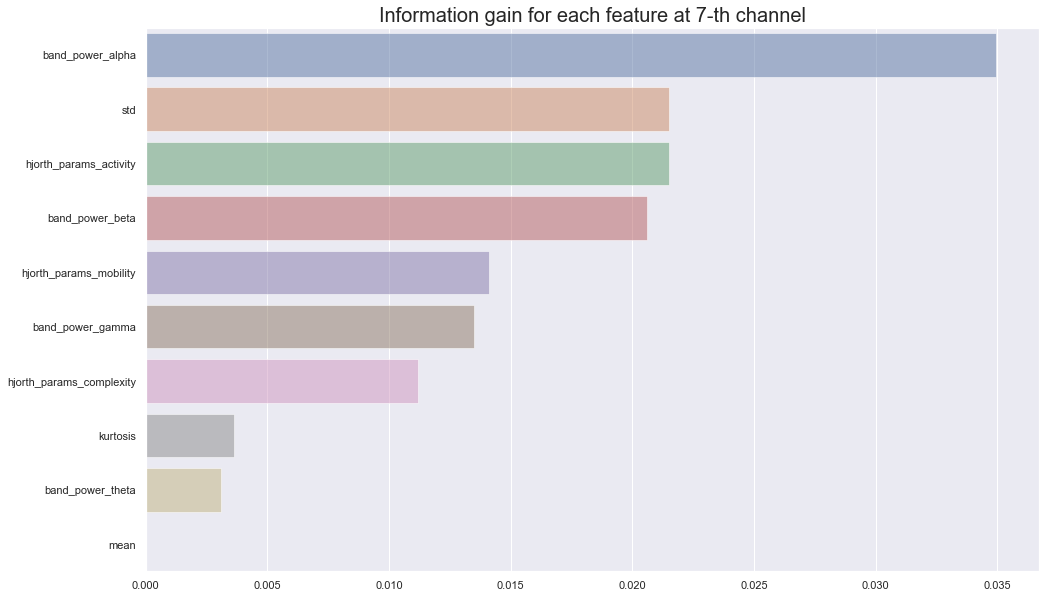

In [46]:
for k in range(8):
    X = df[k]
    y = pd.Series(targets)
    mutual_info = mutual_info_classif(X, y)
    mutual_info_series = pd.Series(mutual_info, index=X.columns)
    mutual_info_series.sort_values(ascending=False, inplace=True)

    # plot mutual information bar plot
    fig, ax = plt.subplots(figsize=(16, 10))
    
    plt.grid()
    sns.set(style='darkgrid')
    plt.grid()
    sns.barplot(x=mutual_info_series.values, y=mutual_info_series.index, alpha=0.5)

    plt.title(f'Information gain for each feature at {k}-th channel', fontdict = {'fontsize' : 20})
    plt.savefig(f'../data/plots/information_gain/ig{k}.png', dpi = 300)

### najrandom svm

In [47]:
participant_ids_C = []
participant_ids_A = []
participant_ids_F = []

for i in range(len(loader)):
    if(loader[i]['group'] == 'A'):
        participant_ids_A.append(i)
    if(loader[i]['group'] == 'C'):
        participant_ids_C.append(i)
    if(loader[i]['group'] == 'F'):
        participant_ids_F.append(i)

In [48]:
len(participant_ids_A)
random.shuffle(participant_ids_A)

len(participant_ids_C)
random.shuffle(participant_ids_C)

len(participant_ids_F)
random.shuffle(participant_ids_F)

train_ids = participant_ids_A[:3*len(participant_ids_A)//4] + participant_ids_C[:3*len(participant_ids_C)//4] + participant_ids_F[:3*len(participant_ids_F)//4]
test_ids = participant_ids_A[3*len(participant_ids_A)//4:] + participant_ids_C[3*len(participant_ids_C)//4:] + participant_ids_F[3*len(participant_ids_F)//4:]

In [49]:
print(len(train_ids))
print(len(test_ids))

10439
3480


In [50]:
train_set = []
test_set = []
labels_train = []
labels_test = []
for i in range(len(loader)):
    arr = loader[i]['data']
    selector = AnalysisSelector()
    selector.selectFeatures(['kurtosis', 'skewness', 'band_power', 'hjorth_params'], pca_components = 8, bands = ['alpha', 'beta', 'gamma'], params=['activity', 'mobility'])
    out = selector.transform(arr)
    features = []
    for k in out.values():
        for j in list(k):
            features.append(j)
    if(i in train_ids):
        train_set.append(features)
        if(loader[i]['group'] == 'C'):
            labels_train.append(0)
        elif(loader[i]['group'] == 'F'):
            labels_train.append(1)
        else:
            labels_train.append(2)
    elif(i in test_ids):
        test_set.append(features)
        if(loader[i]['group'] == 'C'):
            labels_test.append(0)
        elif(loader[i]['group'] == 'F'):
            labels_test.append(1)
        else:
            labels_test.append(2)

In [51]:
from sklearn import svm
from sklearn.metrics import accuracy_score
from pycm import ConfusionMatrix

In [52]:
clf = svm.SVC()
clf.fit(train_set, labels_train)

SVC()

In [53]:
results = clf.predict(test_set)

In [54]:
accuracy_score(results, labels_test) 

0.44626436781609197

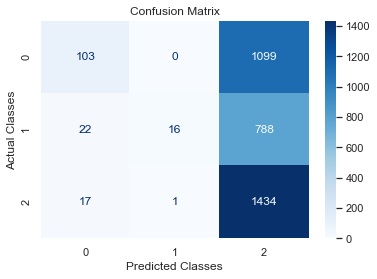

In [55]:
cm = ConfusionMatrix(actual_vector=labels_test, predict_vector=results)
cm.plot(cmap=plt.cm.Blues, number_label=True, plot_lib="seaborn")
plt.show()